In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random

In [2]:
def neighbor_edges_of_node(graph, node):
    neighbor_edges = []
    for edge in graph.edges():
        if node in edge:
            neighbor_edges.append(edge)
    return neighbor_edges

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/ga_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        if coloring_result == -1:
            result_file.write("Time limit exceeded.\n")
            print("Time limit exceeded.\n")
        else:
            if coloring_result:
                result_file.write("Minimum edge coloring found.\n")
                result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
                result_file.write(f"Number of iterations: {iter}\n")

                print("Minimum edge coloring found.")
                print("Number of colors:", len(set(coloring_result)))  
                print("Number of iterations:", iter)
                draw_colored_graph(graph, coloring_result)
                plt.close() 
            else:
                result_file.write("No solution found.\n")
                print("No solution found.\n") 

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:
def is_feasible(solution):
    return any(solution)

In [55]:
class Individual:
    def __init__(self, graph):
        self.graph = graph  
        self.num_of_edges = len(graph.edges())
        self.coloring = [random.randrange(1, len(graph.edges())) for _ in range(len(graph.edges()))]
        self.fitness = self.calc_fitness()  

    
    def calc_fitness(self):
        graph = self.graph
        edge_color = {edge: self.coloring[i] for i, edge in enumerate(graph.edges())}
        num = 0
    
        for edge in graph.edges():
            indicator = True
    
            u, v = edge
            
            u_edges = neighbor_edges_of_node(graph, u)
            v_edges = neighbor_edges_of_node(graph, v)
    
            u_edges.remove(edge)
            v_edges.remove(edge)
            
            for i in range(len(u_edges)):
                if edge_color[u_edges[i]] == edge_color[edge]:
                    indicator = False
            
            for j in range(len(v_edges)):  
                if edge_color[v_edges[j]] == edge_color[edge]:
                    indicator = False
    
            if indicator:
                num += 1

        if is_valid_coloring(graph,self.coloring):
             return len(graph.edges()) - num
        else:
            return -100


In [56]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return max(chosen, key=lambda x: x.fitness)

In [57]:
def crossover(parent1, parent2, child1, child2):
    random_pos = random.randrange(0, len(parent1.coloring))
    
    child1.coloring[:random_pos] = parent1.coloring[:random_pos]
    child1.coloring[random_pos:] = parent2.coloring[random_pos:]
    
    child2.coloring[:random_pos] = parent2.coloring[:random_pos]
    child2.coloring[random_pos:] = parent1.coloring[random_pos:]

In [58]:
def mutation(individual, mutation_prob):
    for i in range(len(individual.coloring)):
        if random.random() < mutation_prob:
            new_color = random.randrange(1, individual.num_of_edges)
            while new_color == individual.coloring[i]:
                new_color = random.randrange(1, individual.num_of_edges)
            individual.coloring[i] = new_color

In [59]:
def genetic_algorithm(graph, population_size, num_generations, tournament_size, elitism_size, mutation_prob):

    population = [Individual(graph) for _ in range(population_size)]
    new_population = population.copy()

    for i in range(num_generations):
        population.sort(key=lambda x: x.fitness, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size) 
            
            crossover(parent1, parent2, child1=new_population[j], child2=new_population[j+1])

            mutation(new_population[j], mutation_prob)
            mutation(new_population[j+1], mutation_prob)
            
            new_population[j].fitness = new_population[j].calc_fitness()
            new_population[j+1].fitness = new_population[j+1].calc_fitness()
        
        population = new_population.copy()
        
    return max(population, key=lambda x: x.fitness)

In [60]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_individual = genetic_algorithm(graph, 
                                                population_size=100,
                                                num_generations=10,
                                                tournament_size=7,
                                                elitism_size=10,
                                                mutation_prob=0.05)
            end_time = time.time()

            coloring_result = best_individual.coloring

            write_output(graph, file, coloring_result, 10,start_time, end_time)     

Running test graph_3_edges.txt...
[2, 2, 2]
Minimum edge coloring found.
Number of colors: 1
Number of iterations: 10


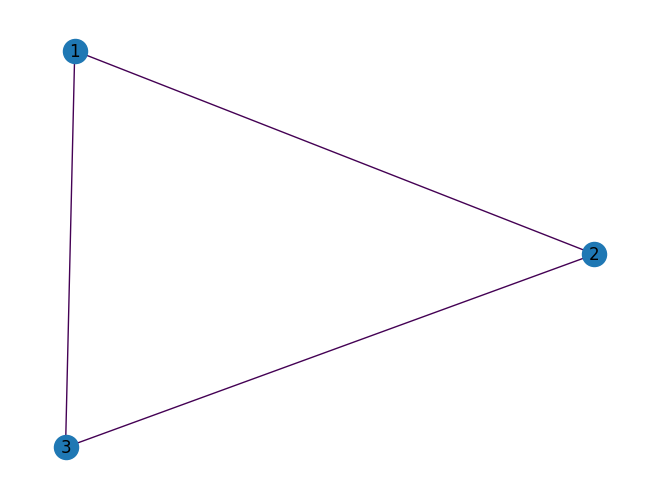

Time taken: 0.051550865173339844 seconds

Running test graph_5_edges.txt...
[2, 3, 1, 3, 4]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 10


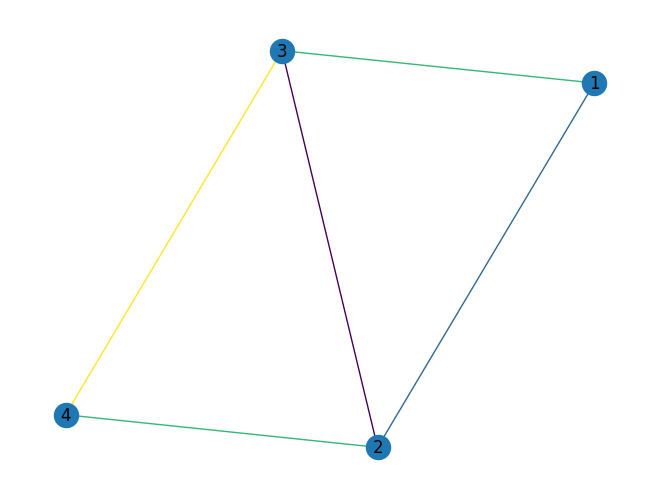

Time taken: 0.06900525093078613 seconds

Running test graph_5_edges_2.txt...
[3, 1, 2, 2, 3]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 10


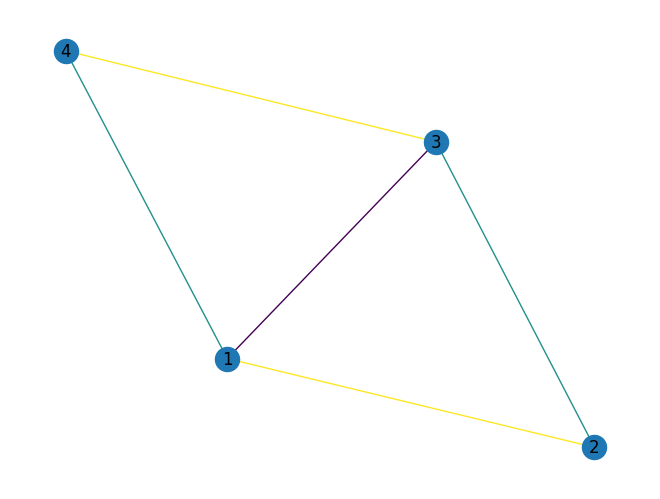

Time taken: 0.06612348556518555 seconds

Running test graph_6_edges.txt...
[4, 2, 1, 3, 4, 5]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 10


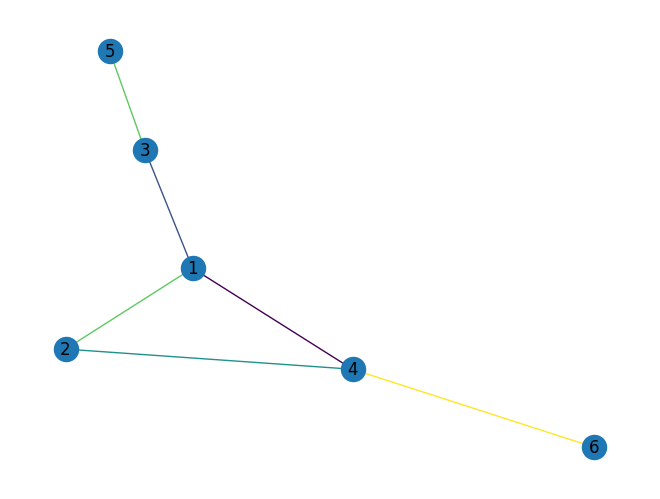

Time taken: 0.08758234977722168 seconds

Running test graph_7_edges.txt...
[2, 3, 6, 3, 5, 4, 5]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 10


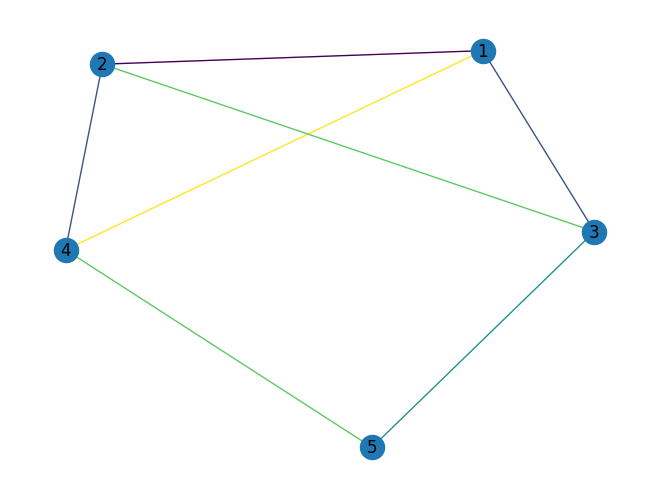

Time taken: 0.1012725830078125 seconds

Running test graph_7_edges_2.txt...
[3, 2, 6, 4, 5, 3, 4]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 10


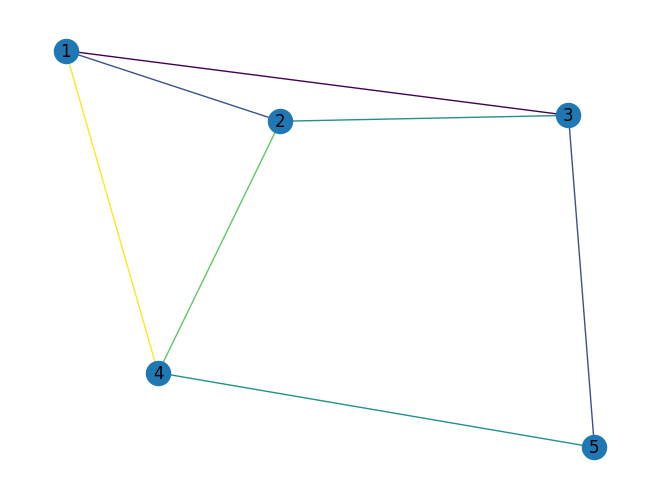

Time taken: 0.09917235374450684 seconds

Running test graph_7_edges_3.txt...
[2, 3, 5, 1, 1, 1, 5]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 10


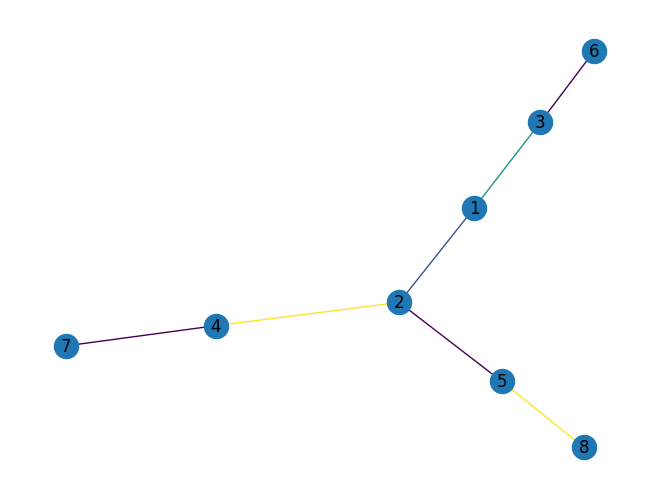

Time taken: 0.11602497100830078 seconds

Running test graph_8_edges.txt...
[3, 6, 1, 2, 4, 4, 7, 6]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 10


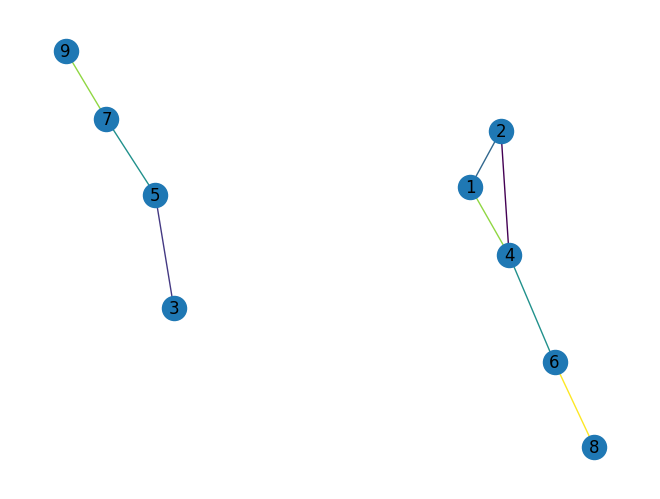

Time taken: 0.13373517990112305 seconds

Running test graph_9_edges.txt...
[2, 5, 7, 4, 6, 2, 6, 8, 4]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 10


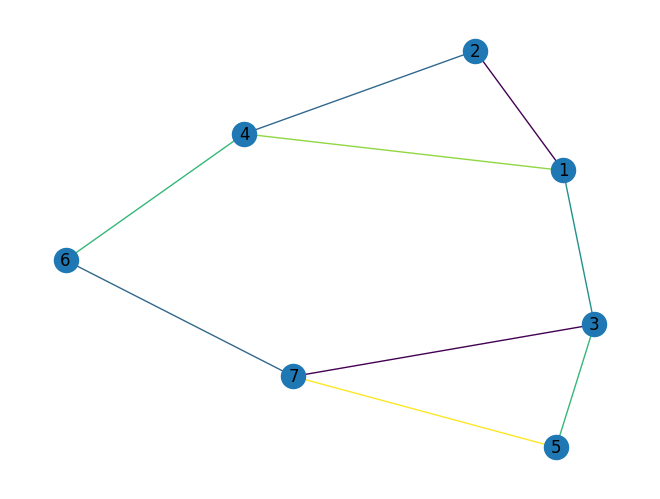

Time taken: 0.17866945266723633 seconds

Running test graph_9_edges_2.txt...
[1, 6, 8, 3, 4, 4, 2, 8, 8]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 10


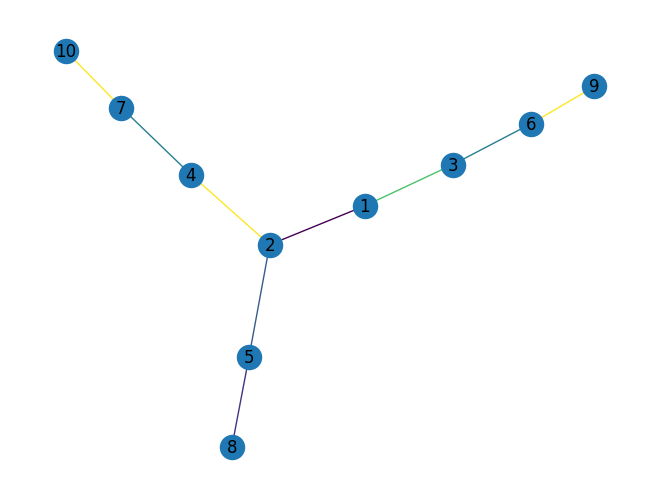

Time taken: 0.15770292282104492 seconds

Running test graph_10_edges.txt...
[6, 3, 9, 3, 8, 3, 4, 3, 7, 2]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 10


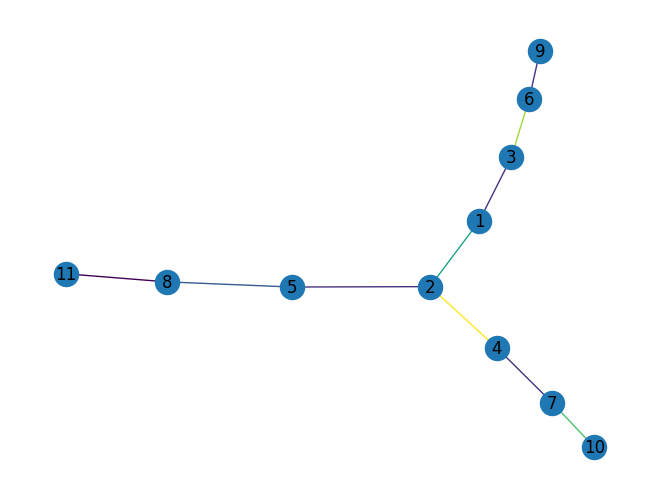

Time taken: 0.19886302947998047 seconds

Running test graph_10_edges_2.txt...
[4, 1, 6, 3, 5, 2, 9, 3, 1, 9]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 10


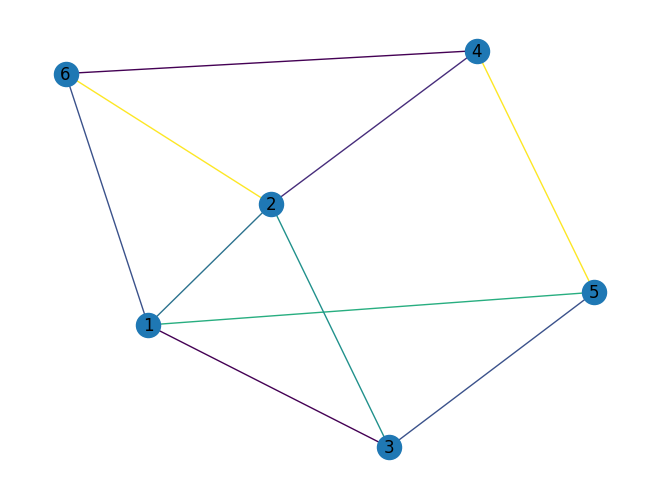

Time taken: 0.16762804985046387 seconds

Running test graph_10_edges_3.txt...
[3, 6, 2, 6, 1, 5, 9, 4, 1, 3]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 10


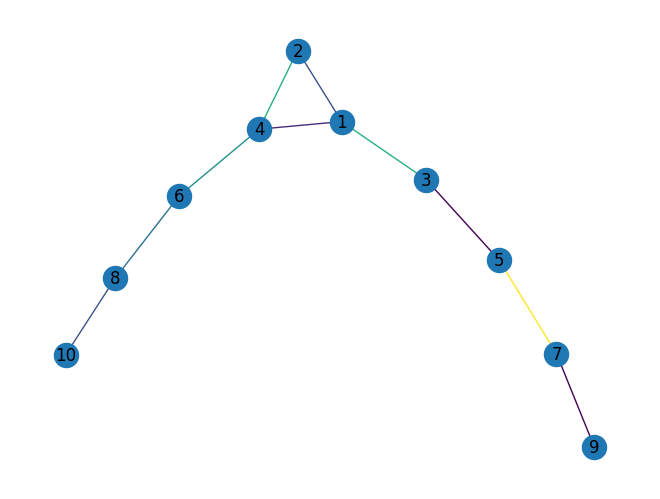

Time taken: 0.20695209503173828 seconds

Running test graph_11_edges.txt...
[3, 9, 6, 10, 1, 5, 2, 7, 3, 9, 7]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 10


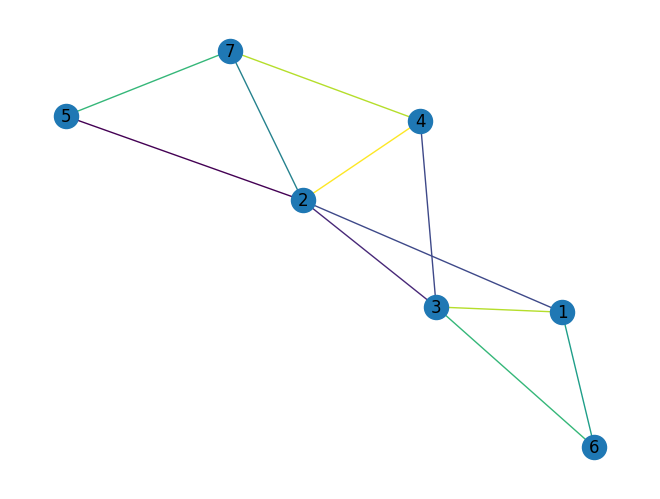

Time taken: 0.1854994297027588 seconds

Running test graph_11_edges_2s.txt...
[1, 9, 4, 5, 7, 3, 10, 2, 1, 9, 6]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 10


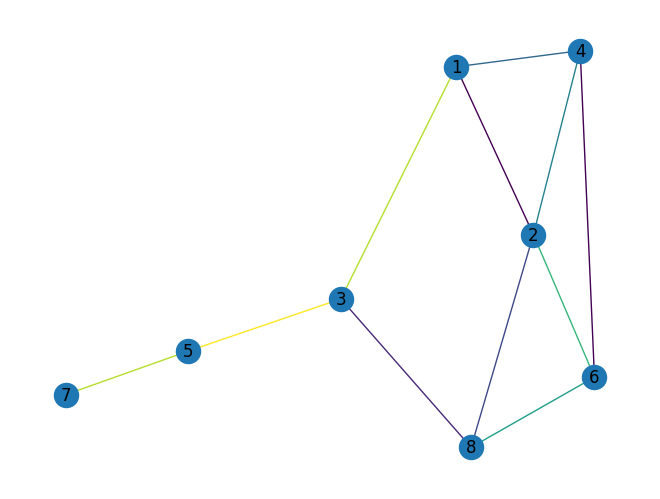

Time taken: 0.20229625701904297 seconds

Running test graph_11_edges_3.txt...
[2, 9, 4, 8, 8, 3, 5, 6, 1, 7, 3]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 10


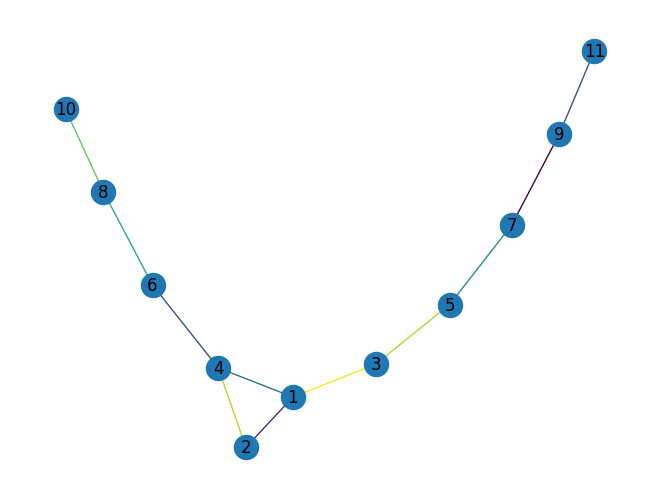

Time taken: 0.23230886459350586 seconds

Running test graph_11_edges_4.txt...
[5, 6, 10, 2, 1, 8, 8, 9, 5, 9, 10]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 10


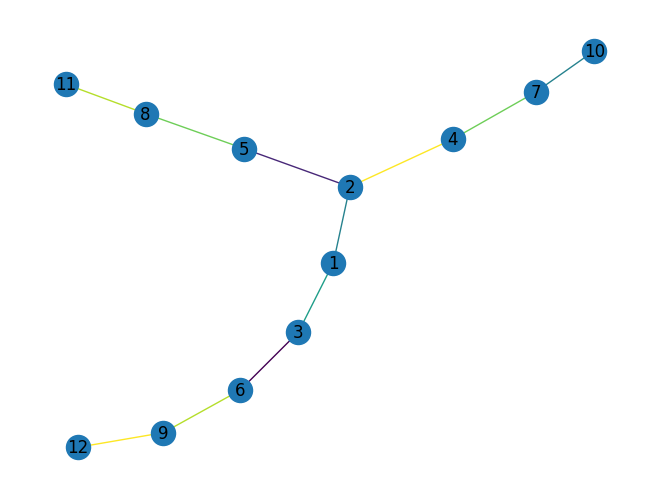

Time taken: 0.21513772010803223 seconds

Running test graph_12_edges.txt...
[11, 7, 4, 6, 10, 5, 8, 1, 4, 2, 9, 8]
Minimum edge coloring found.
Number of colors: 10
Number of iterations: 10


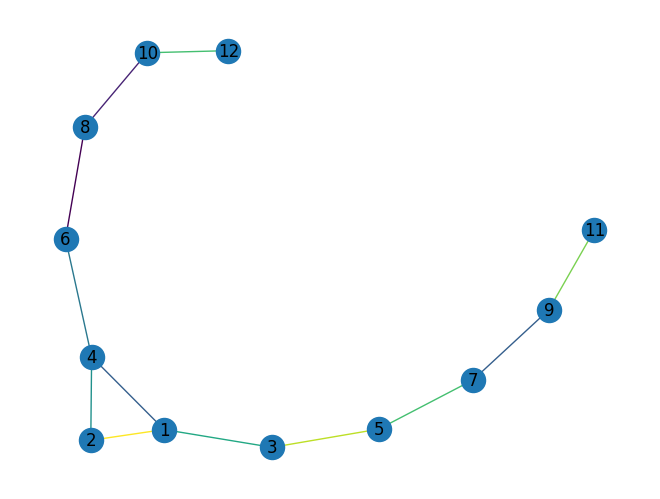

Time taken: 0.27317070960998535 seconds

Running test graph_12_edges_2.txt...
[7, 6, 4, 11, 7, 7, 9, 3, 5, 6, 5, 3]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 10


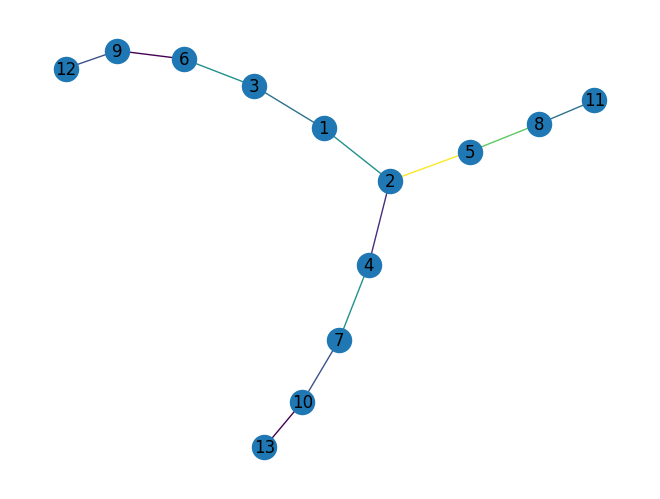

Time taken: 0.27521181106567383 seconds

Running test graph_15_edges.txt...
[11, 9, 12, 5, 14, 13, 5, 6, 8, 4, 8, 10, 14, 7, 2]
Minimum edge coloring found.
Number of colors: 12
Number of iterations: 10


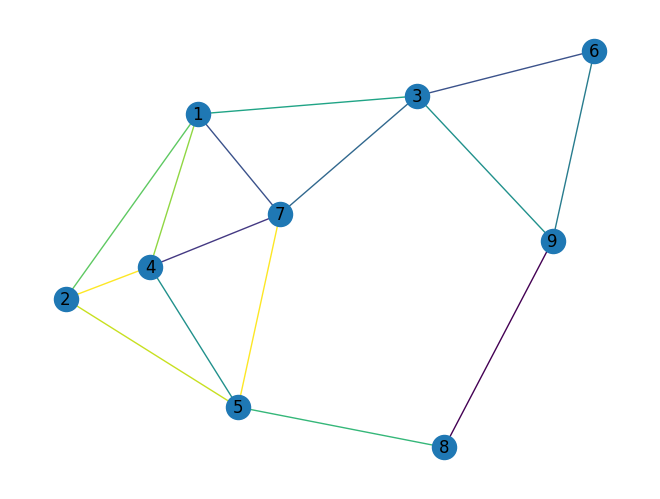

Time taken: 0.2986757755279541 seconds



In [61]:
run_tests('./tests')